# Modeling

In this notebook we will train a model that will learn from the search sequences that the users have emitted. We will use directly the feature that we engineered in the las notebook to extract our data.

First we will decide which model we will be using. Then we will create the required building blocks for processing our data and training our model. Hopefully we will have time to create a way to test and compare all the trained models so we can choose the best one.

***The answer to the questions can be found here: ***
- [Answer to second question](#cell_second_question)
- [Answer to third question](#cell_third_question)
- [Answer to fourth question](#cell_fourth_question)




In [19]:
from os import path
import pandas as pd
import os
from tools import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

Let's load the data from the last notebook. 

In [20]:
df_original = pd.read_csv('data/enhanced/df_modeling.csv')
# Make sure that Nan values are encoded as ''
df_original.replace(np.nan, '', regex=True, inplace=True)

# Let's transform the search sequences back to numpy arrays so we can work with them.
df_original['city_integer_sequence'] = df_original['city_integer_sequence'].apply(strings_to_list)

df_original.head()


,session_id,unix_timestamp,cities,user_id,joining_date,country,cities_searched,city_integer_sequence,binary_sequence,country_code
0,X061RFWB06K9V,1442503708,"New York NY, Newark NJ",2024,2015-03-22,UK,2,"[51, 52]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,5AZ2X2A9BHH5U,1441353991,"New York NY, Jersey City NJ, Philadelphia PA",2853,2015-03-28,DE,3,"[51, 33, 59]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
2,SHTB4IYAX4PX6,1440843490,San Antonio TX,10958,2015-03-06,UK,1,[71],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,JBRB8MZGTX3M4,1427268063,Edmonton AB,7693,2015-03-12,IT,1,[21],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
4,YJCMPURC2FL9C,1430559067,"Phoenix AZ, Houston TX",7506,2015-02-28,UK,2,"[60, 30]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [21]:
df_original.info()
# print(type(df_original['city_integer_sequence'].values[0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 10 columns):
session_id               20022 non-null object
unix_timestamp           20022 non-null int64
cities                   20022 non-null object
user_id                  20022 non-null int64
joining_date             20022 non-null object
country                  20022 non-null object
cities_searched          20022 non-null int64
city_integer_sequence    20022 non-null object
binary_sequence          20022 non-null object
country_code             20022 non-null int64
dtypes: int64(4), object(6)
memory usage: 1.5+ MB


The dataframe exactly as we had it on last notebook.

Let's recover the list of all cities that we saved to 'data/city_list.json' on last notebook. We will use it several times here as well.

In [22]:
# Recover the city list that we had saved last time
with open('data/city_list.json', 'r') as f:
        city_list = list(json.load(f)['city_list'])
        
print(city_list)

['Anaheim CA', 'Arlington TX', 'Atlanta GA', 'Austin TX', 'Bakersfield CA', 'Baltimore MD', 'Birmingham AL', 'Boston MA', 'Buffalo NY', 'Calgary AB', 'Chandler AZ', 'Charlotte NC', 'Chesapeake VA', 'Chicago IL', 'Cincinnati OH', 'Cleveland OH', 'Columbus OH', 'Corpus Christi TX', 'Dallas TX', 'Detroit MI', 'Edmonton AB', 'Fort Wayne IN', 'Fort Worth TX', 'Fresno CA', 'Glendale AZ', 'Greensboro NC', 'Halifax NS', 'Hamilton ON', 'Hialeah FL', 'Houston TX', 'Indianapolis IN', 'Jacksonville FL', 'Jersey City NJ', 'Kansas City MO', 'Kitchener ON', 'Lexington KY', 'Lincoln NE', 'London ON', 'Long Beach CA', 'Los Angeles CA', 'Louisville KY', 'Madison WI', 'Memphis TN', 'Mesa AZ', 'Miami FL', 'Milwaukee WI', 'Minneapolis MN', 'Montreal QC', 'Nashville TN', 'New Orleans LA', 'New York NY', 'Newark NJ', 'Norfolk VA', 'OTTAWA ON', 'Oakland CA', 'Oklahoma City OK', 'Omaha NE', 'Oshawa ON', 'Philadelphia PA', 'Phoenix AZ', 'Pittsburgh PA', 'Plano TX', 'Portland OR', 'Quebec QC', 'Raleigh NC', 'Riv

In [23]:
df_original.sort_values(['cities_searched'], ascending=False).head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,cities_searched,city_integer_sequence,binary_sequence,country_code
4818,KHH2D79TU73O6,1431465585,"Montreal QC, Boston MA, New York NY, Jersey Ci...",5644,2015-03-21,US,11,"[48, 8, 51, 33, 52, 6, 87, 53, 13, 65, 26]","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",5
15510,PGBYV8JNV13LC,1442481402,"New York NY, Jersey City NJ, Newark NJ, Philad...",3196,2015-03-15,,9,"[51, 33, 52, 59, 87, 13, 86, 65, 12]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",0
2698,3R4UV4V398B60,1443269955,"Chicago IL, Madison WI, Milwaukee WI, Fort Way...",4273,2015-03-17,IT,8,"[14, 42, 46, 22, 80, 20, 16, 61]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",3
9356,X0UD44Z9EF7ZI,1429279640,"Montreal QC, OTTAWA ON, Oshawa ON, Toronto ON,...",6513,2015-03-02,FR,8,"[48, 54, 58, 81, 35, 28, 68, 9]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",6
12607,GPMBRPR9EYZA7,1434559155,"New York NY, Jersey City NJ, Newark NJ, Baltim...",5200,2015-03-29,UK,8,"[51, 33, 52, 6, 87, 53, 86, 13]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1


In [24]:
df_original['cities_searched'].describe()

count    20022.000000
mean         1.648986
std          0.874272
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         11.000000
Name: cities_searched, dtype: float64

Only 25% of the data has searches between 2 and 11 cities, all the remaining 75% represents searches for one or two cities. Since we want to predict the next searched city given a sequence of cities then ***we will only consider searches that include more than one city***. Let's remove all the searches that have only one city and see what data remains. We will loose around half of our data with this. We'll soon find if it is the best solution.

In [25]:
df_relevant_sequences = df_original[df_original['cities_searched'] > 1]
df_relevant_sequences.shape

(9351, 10)

In [26]:
df_relevant_sequences.describe()

,unix_timestamp,user_id,cities_searched,country_code
count,9.351000e+03,9351.000000,9351.000000,9351.000000
mean,1.435066e+09,5494.582611,2.389584,2.866431
std,4.988852e+06,3202.799299,0.779397,2.003264
min,1.425210e+09,4.000000,2.000000,0.000000
25%,1.430808e+09,2710.000000,2.000000,1.000000
50%,1.435048e+09,5443.000000,2.000000,2.000000
75%,1.439374e+09,8314.000000,3.000000,5.000000
max,1.443747e+09,10990.000000,11.000000,6.000000


Now we have only 9351 datapoints. We lost half of our data! But now we are sure that the search sequences have at have at least two cities so we can use them for some sort of sequential model.
Let's split our sequences so that we take the last elements of each sequence and put them into a list to be used as our targets. The remaining elements in each sequence will be used as the set of observations.

## Model choice

It is time to choose a model to train in order to be able to predict the potentially next cities in a sequence.
The search sequences already tokenized already tokenized in the last notebook look like this:

In [27]:
list(df_original.sort_values(['cities_searched'], ascending=False)['city_integer_sequence'].values)[:10]

[array([48,  8, 51, 33, 52,  6, 87, 53, 13, 65, 26]),
 array([51, 33, 52, 59, 87, 13, 86, 65, 12]),
 array([14, 42, 46, 22, 80, 20, 16, 61]),
 array([48, 54, 58, 81, 35, 28, 68,  9]),
 array([51, 33, 52,  6, 87, 53, 86, 13]),
 array([32, 79,  3,  7, 49, 36, 17]),
 array([51, 33, 59, 52,  6, 53, 13]),
 array([19, 23,  2,  4, 30, 71, 18]),
 array([30,  4, 23, 56, 62, 19,  2]),
 array([51, 33,  6, 87, 13, 53, 65])]

In [28]:
print(df_original.sort_values(['cities_searched'], ascending=False)['city_integer_sequence'][1])
print(df_original.sort_values(['cities_searched'], ascending=False)['cities'][1])

[51 33 59]
New York NY, Jersey City NJ, Philadelphia PA


The most inviting thing to do is to use the sequences directly as observations in order to predict what character would be next given a sequence. In order to achieve this we will have to process our data accordingly so we split the sequences as effectively as possible so we maximize the quantity of data and preserve the sequential patterns of the observations. 

We will use a Recurrent Neural Network with LSTM layers as a model. Nowadays RNN based models are known to be among the most performant methods of sequence classification and sequence generation. 

We will approach this problem as a classification with as many classes as different cities are in the data. So we will have 89 different classes among which to classify 9351 sequences. The number of classes seems pretty big for the number of data points, we need more observations. We will have to enhance our data by decomposing the sequences into more sequences that provide us with sequential patterns.

## Processing

Let's decompose our sequences in a way that maximizes the amount of data without losing any sequential relationships within each sequence, in other words; without shuffling them or creating any new ones. 

We will decompose each sequence as follows:
```
[30,  4, 23, 56] - > ([30,  4, 23], 56)
[30,  4, 23]     - > ([30,  4], 23)
[30,  4]         - > ([30], 4)
```
Each sequence will be split into a pair of itself without the last element and its last element. Then we will apply this recursively until the number of elements allows it.
The single values in the rightmost side of the output at each round will be used as the labels (y) and the left values as observations. 


In [29]:
def enhance_sequences(sequences):
    """
    Enhance sequential data by spliting each sequence into several sequences that preserve sequential patterns.
    :param x: List of sequences.
    :return: X and y list. Where X contains the obserations and y de labels.
    """
    X = []
    y = []
    
    for seq in sequences:
        X_seq, y_seq = split_sequence(seq)
        X.extend(X_seq)
        y.extend(y_seq)
        
    # reshape
    X = np.asarray(X)
    y = np.asarray(y)

    return X, y

def split_sequence(sequence):
    """
    Split sequence and extract observations and labels.
    :param x: Sequence.
    :return: X and y list. Where X contains the obserations and y de labels.
    """
    
    X = []
    y = []    
    # Invert the sequence
    inverted = np.array(sequence)[::-1]
    # Enumerate through inverted sequence minus the last element
    for idx, token in enumerate(inverted[:-1]):
        # Save from the second element all the way to the end of the inverted sequence as an observation
        X.append(np.asarray(inverted[idx+1:][::-1]))
        # Save the firt element in the inverted sequence as a label
        y.append(token)
        
    X = np.asarray(X)
    y = np.asarray(y)

    return X, y
        

Let's use a test sequence to verufy that our transformation functions perform as expected.

In [30]:
test_sequences = [[50, 32, 58], [48, 54, 58, 81, 35, 28, 68, 9], [51, 33, 52, 6, 87, 53, 86, 13]]

In [31]:
X,y = enhance_sequences(test_sequences)
print ('--- Original ----')
print(test_sequences)
print ('--- Observations ----')
print (X)
print ('--- Labels ----')
print (y)

# Verify that there are the same number of elements in each list.
assert len(X) == len(y)
print('Sets of length: ' + str(len(X)))

--- Original ----
[[50, 32, 58], [48, 54, 58, 81, 35, 28, 68, 9], [51, 33, 52, 6, 87, 53, 86, 13]]
--- Observations ----
[array([50, 32]) array([50]) array([48, 54, 58, 81, 35, 28, 68])
 array([48, 54, 58, 81, 35, 28]) array([48, 54, 58, 81, 35])
 array([48, 54, 58, 81]) array([48, 54, 58]) array([48, 54]) array([48])
 array([51, 33, 52,  6, 87, 53, 86]) array([51, 33, 52,  6, 87, 53])
 array([51, 33, 52,  6, 87]) array([51, 33, 52,  6]) array([51, 33, 52])
 array([51, 33]) array([51])]
--- Labels ----
[58 32  9 68 28 35 81 58 54 13 86 53 87  6 52 33]
Sets of length: 16


We have split our search sequences into a single element that will be used as training labels (y) and a set of sequences with the las element to the right removed (X) Now we will be able to train a supervised model passing the y set as classes to predict. Therefore our model will learn what token (city searched) comes after a sequence of cities. This encoding will encode the order and the precesnce of each one of the searched cities into a sequence of integers (soon to be hot encoded).
Now we need to pad our sequences so they are all the same length. Let's pad them to the maximum length of the sequences in set X.

So the maximum length of all sequences in set X is 10. This makes sense since we had realized that the overal maximum length was 11. After removing the last entry it makes sense now that the max length is 10.
Lets pad our sequences so that they are all the same length. We will fill them up with zeros until they are the size of the maximum length of all the sequences.

In [32]:
from keras.preprocessing.sequence import pad_sequences;

def pad_sequece(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    return pad_sequences(x,maxlen=length,padding='post')

In [33]:
padded = pad_sequece(test_sequences)
assert len(padded[0]) == len(max(test_sequences)), 'Dimensions are not equal'
print('Sequences of length: ' + str(len(padded[0])))
print(padded)

fixed_size = 5
padded = pad_sequece(test_sequences, fixed_size)
assert len(padded[0]) == fixed_size, 'Dimensions are not equal'
print('Sequences of length: ' + str(len(padded[0])))
print(padded)

Sequences of length: 8
[[50 32 58  0  0  0  0  0]
 [48 54 58 81 35 28 68  9]
 [51 33 52  6 87 53 86 13]]
Sequences of length: 5
[[50 32 58  0  0]
 [81 35 28 68  9]
 [ 6 87 53 86 13]]


Our padding method seems to work. Let's now write a couple of methods to hot encode a matrix of sequences. Let's rememeber that hot encoding is the process of assigining an integer a vector of zeros of length D whith the 

In [34]:
def one_hot_encode_matrix(sequences, dimension):
    processed_seqs = []
    for seq in sequences:
        processed_seqs.append(one_hot_encode_list(seq, dimension))
    return processed_seqs

def one_hot_encode_list(seq, dimension):
    encoded_sequences = []
    for token in seq:
        encoded = [0]*dimension
        encoded[token-1] = 1
        encoded_sequences.append(encoded)
        
    return encoded_sequences

In [35]:
encoded_sequences = one_hot_encode_list(test_sequences[0], len(city_list))
assert len(test_sequences[0]) == len(encoded_sequences)
assert encoded_sequences[0][test_sequences[0][0]-1] == 1

print(str(test_sequences[0][0]) + ' : ' + str(encoded_sequences[0]))

50 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [36]:
encoded = one_hot_encode_matrix(test_sequences, len(city_list))

# Verify that there is one 1 in each encoded vector
assert sum(encoded[0][0]) == 1
# Verify that the length of the list of vectors equals the length of the original list.
assert len(encoded) == len(test_sequences), 'Somethings wrong with the size of the list'
# Verify that the values are properli encoded, ie; verify that the one is at the right place
assert test_sequences[0][0] == np.argmax(encoded[0][0]) + 1 , 'The "1" is at the wrong place'
# Verify that the length of each hot encoded vector is equal to the length of the list of cities.
assert len(encoded[0][0]) == len(city_list), 'Something wrong with the length of the encoded vectors'

This is how our data will look when we put it into the model. Each observation sequence will be a list of binary vectors of length 89 with only one entry set to one which encodes the class (city) that each vector represents.

This is the way our LSTM will be able to get the most of our data.


### Processing pipeline

Let's now combine the methods that we wrote above into one single method that we will then use to process all our data and have it ready for modeling.

In [37]:
def preprocess(sequences, max_seq_length):
    # Step 1: Enhance sequences
    X_tokens,y_tokens = enhance_sequences(sequences)
    assert len(X_tokens)  == len(y_tokens) 
    print('Working with an original of  ' + str(len(sequences)) + ' sequences')
    print('Working with ' + str(len(X_tokens)) + ' prepared sequences')
    print(y_tokens)
    assert min(y_tokens) == 1
    assert max(y_tokens) == 89
    
    # Step 2 : Padd the sequences to the number of classes
    X_padded = pad_sequece(X_tokens, max_seq_length)
    # Verify that the length of each encoded vector is the same as the maximum sequence length
    assert len(X_padded[0]) == max_seq_length
    print('Padded sequences of length: ' + str(len(X_padded[0])))
    # Verify that length of list is preserved.
    assert len(X_padded) == len(X_tokens)  
    print(X_padded[0])
    
    # Step 3 : Hot encode the observations and  the labels 
    X = one_hot_encode_matrix(X_padded, len(city_list))
    y = one_hot_encode_list(y_tokens, len(city_list))
    
    return X, y

Lets define a method to split our data into testing and training sets. 

In [38]:
# split our dataset into training / testing sets

def split_data(X, y, train_test_split):
    # partition the training set
    X_train = X[:train_test_split]
    y_train = np.asarray(y[:train_test_split])

    assert len(X_train) == len(y_train)
    print('Training samples :' + str(len(X_train)))

    # keep the last chunk for testing
    X_test = X[train_test_split:]
    y_test = np.asarray(y[train_test_split:])

    assert len(X_test) == len(y_test)
    print('Testing samples :' + str(len(X_test)))

    # Reshape the data to be able to put it into Keras' LSTM module
    X_train = np.asarray(np.reshape(X_train, (len(X_train), max_seq_length, len(city_list))))
    X_test = np.asarray(np.reshape(X_test, (len(X_test), max_seq_length, len(city_list))))

    # Reshape labels to work with Keras's sparse_categorical_crossentropy 
    y_train = np.asarray(np.reshape(y_train, (y_train.shape[0], len(city_list))))
    y_test = np.asarray(np.reshape(y_test, (y_test.shape[0], len(city_list))))
    
    return X_train, X_test, y_train, y_test

## Model

Let's create a method to define our model's architecture. Inside this method we will decide which layers to use for our Neural Network.

In [39]:
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Dropout
import keras

In [40]:
def create_model(optimizer):
    
#     # Alternate architecture
#     model = Sequential()
#     model.add(LSTM(units=160, input_shape=(max_seq_length, len(city_list))))
#     model.add(Dense(units=len(city_list), activation='softmax'))

    model = Sequential()
    model.add(LSTM(units=100, input_shape=(max_seq_length, len(city_list)), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dense(units=len(city_list), activation='softmax'))

    # compile model --> make sure initialized optimizer and callbacks - as defined above - are used
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    model.summary()
    
    return model

Let's write a method to save the results of our training to disk so we can look back at it later.

In [41]:
def save_model(model, model_history, path):
    if not os.path.exists(path):
        os.makedirs(path)

    # Save model architecture
    with open(path + '/' + 'model_architecture.json', 'w') as json_file:
        json.dump(model.to_json(), json_file)
        print('Saving model architecture at path:' + path)


    # Save model weigths
    model.save_weights(path + '/' + 'model_weights.hdf5')
    print('Saving model weigths at path:' + path)
    
    # Save model loss
    with open(path + '/' + 'loss.json', 'w') as json_file:
        json.dump({'loss':model_history.history['loss'],'val_loss':model_history.history['val_loss']}, json_file)
        print('Saving model loss at path:' + path)

In [42]:
# Plot training & validation loss values
def plot_model_loss(loss, val_loss):
    plt.figure(figsize=(15,7));
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Let's create a method that gorups all the building blocks that we have been building in this notebook. The method will receive the relevant sequences, the length of the city list (number of classes) and a path. It wil process the data, train the model and save the results to disk so we can use them later.

In [43]:
def model_training_peipeline(all_relevant_sequences, max_seq_length, path):
    # Process all the relevant sequences
    X, y = preprocess(all_relevant_sequences, max_seq_length)
    # Chose where to split the data
    train_test_split = int(len(X)*0.8)
    X_train, X_test, y_train, y_test = split_data(X, y, train_test_split)
    # initialize optimizer
    optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    # optimizer = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)
    model = create_model(optimizer)
    # train the model and save a reference to its history so we can use it later.
    model_history = model.fit(X_train, y_train, batch_size=128, epochs=100,verbose = 1, validation_split=0.2)

    save_model(model, model_history, path)
    
    return model, model_history, X_test, y_test


In [44]:
# all_relevant_sequences = df_relevant_sequences['city_integer_sequence'].values
# max_seq_length = max([len(seq) for seq in all_relevant_sequences]) - 1
# print('Maximum length of observed sequences : ' + str(max_seq_length))

Maximum length of observed sequences : 10


### Train model using all the data points 

Let's train an LSTM model using all the data points  with search seqeunces of length > 1. Let's see how it goes.

Maximum length of observed sequences : 10
Working with an original of  9351 sequences
Working with 12994 prepared sequences
[52 59 33 ... 84 48 51]
Padded sequences of length: 10
[51  0  0  0  0  0  0  0  0  0]
Training samples :10395
Testing samples :2599
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 100)           76000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 89)                8989      
Total params: 165,389
Trainable params: 165,389
Non-trainable params: 0
_________________________________________________________________
Train on 83

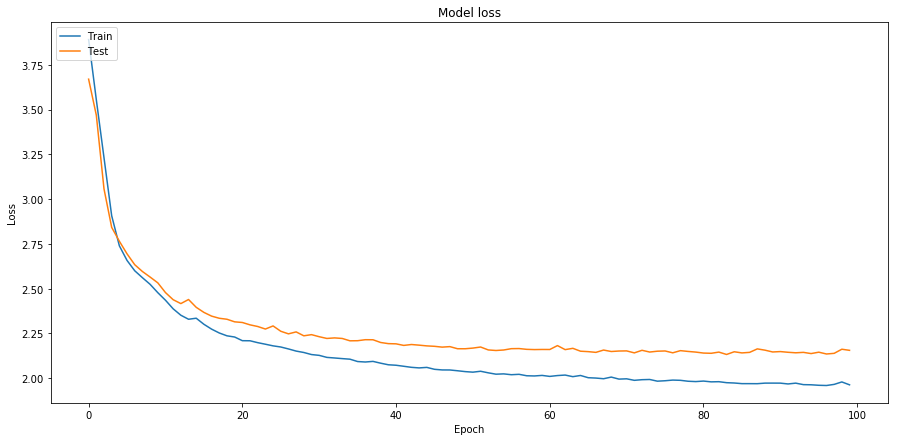

In [38]:
all_relevant_sequences = df_relevant_sequences['city_integer_sequence'].values

max_seq_length = max([len(seq) for seq in all_relevant_sequences]) - 1
print('Maximum length of observed sequences : ' + str(max_seq_length))

# Save the time at which training starts so we can use it to create the paths in which we will store the model details.
training_start_time = np.datetime64('now')

#Create a path to store model details
path = 'models/all_data/{}'.format(str(training_start_time).replace(':', ''))

model, model_history, X_test, y_test = model_training_peipeline(all_relevant_sequences, max_seq_length, path)
plot_model_loss(model_history.history['loss'], model_history.history['val_loss'])

<a id='cell_second_question'></a>

## Answer to second question 

***Question***: Given a sequence of searched cities, find the most likely city or cities to be also
searched next, within the same session. Your code should include a function that takes
a list of 0 to n cities and returns the most likely next city or cities. Keep in mind that the
goal is to call this function each time a user performs a search. It should therefore be fast
to execute.

We have created a method called predict_most_likely_cities that will receive a sequence of cities and transform them accordingly in order to be able to put it into the loadad model and do a prediction. The method will explore the 5 highest ranking predictions for each data point and return us the ones that are not in the original sequence. This way we can be sure that the returned cities will allways be relevant. The returned sequences will be sorted in order of relevance from left to right.

In [45]:
def predict_most_likely_cities(model,input_cities,number_of_most_relevant_predictions,max_seq_length, verbose=False):
    """
    Predict most likely cities to be searched next given a sequence.
    :param model: Model to make prediction with.
    :param input_cities: Sequence of cities to be used as an observation.
    :param number_of_most_relevant_predictions: How many highest ranking predictions to consider when predicting
    :param max_seq_length: Maximum length of sequences
    :return: List of most likely cities to be searched next.
    """
    input_tokens = tokenize_city_sequence(input_cities, city_list)
    padded = pad_sequece([input_tokens], length = max_seq_length)
    
    if verbose:
        print('Input city names: ' + str(input_cities))
        print('Input city tokens: ' + str(input_tokens))
        print('Padded  sequence: ' + str(padded))
        
    # Hot encode the padded input sequence
    X_test = one_hot_encode_matrix(padded, len(city_list))
    # Reshape it to be put into the model
    X_test = np.asarray(np.reshape(X_test, (len(X_test), max_seq_length, len(city_list))))
    
    # Make this round's prediction
    print('Prediction time:')
    test_predict = model.predict(X_test,verbose = True)[0]
    
    ordered_predictions = extract_most_relevant_predictions(test_predict, number_of_most_relevant_predictions, verbose)
    decoded_predictions = decode_sequence(ordered_predictions, city_list)
    
    if verbose:
        print('Decoded predictions: '+ str(decoded_predictions))
        print('----')
    
    return list(set(decoded_predictions) - set(input_cities))


Let's grab a couple of sample sequences of city names.

In [46]:
input_city_names = [['Vancouver BC', 'Victoria BC', 'Seattle WA', 'Portland OR', 'Stockton CA', 'Sacramento CA'],
                    ['Chicago IL', 'Madison WI', 'Milwaukee WI', 'Fort Wayne IN', 'Toledo OH', 'Detroit MI', 'Cleveland OH', 'Pittsburgh PA'],
 ['Montreal QC', 'OTTAWA ON', 'Oshawa ON', 'Toronto ON', 'Kitchener ON', 'Hamilton ON', 'Saint Catharines-Niagara ON', 'Buffalo NY'],
 ['Jacksonville FL', 'Tampa FL, Atlanta GA', 'Birmingham AL', 'Nashville TN', 'Lexington KY', 'Columbus OH']]

# Check that the tokenizer works as expected
tokenize_city_sequence(input_city_names[0], city_list)

[84, 85, 77, 63, 78, 67]

Tokenization seems to be working well.

In [47]:
# Load our best ranking model to see how it performs on some random samples
path = 'models/all_data/{}'.format('2019-11-11T190647')
model_all_data = load_model(path)

In [48]:
print('------------------')
print('Cities most lilely to be searched next')
print('------------------')

# Set number of highest predictions given by the model to consider
number_of_most_relevant_predictions = 5

most_probable_cities = predict_most_likely_cities(model_all_data,input_city_names[1], 
                                                      number_of_most_relevant_predictions,
                                                      max_seq_length,
                                                      verbose=True)

print('Cities most lilely to be searched next: ' + str(most_probable_cities))

------------------
Cities most lilely to be searched next
------------------
Input city names: ['Chicago IL', 'Madison WI', 'Milwaukee WI', 'Fort Wayne IN', 'Toledo OH', 'Detroit MI', 'Cleveland OH', 'Pittsburgh PA']
Input city tokens: [14, 42, 46, 22, 80, 20, 16, 61]
Padded  sequence: [[14 42 46 22 80 20 16 61  0  0]]
Prediction time:
1/1 [==============================] - 0s 162ms/step
Indexes of predictions with highest scores: [48 15 19 60 88]
Probability distributions: [0.04178939 0.10462419 0.14027882 0.41342157 0.07039583]
5 most probable cities: [61 20 16 89 49]
Decoded predictions: ['Pittsburgh PA', 'Detroit MI', 'Cleveland OH', 'Windsor ON', 'Nashville TN']
----
Cities most lilely to be searched next: ['Windsor ON', 'Nashville TN']


***So the method above is the answer for the second question***. The prediction itself takes 183 microseconds to execute so if we go with a model like this one in terms of speed we will have no problems.

I've also created the method bellow, it that will generate as many new cities as we ask from it. The generated sequence will be the product of taking the original sequence and predicting the next character, then repeating the same iteratively until the length of the predicted sequence is as desired. This method was done for fun and it does not correspond directly yo any of the questions in the pdf document.


In [49]:
def predict_next_cities(model,input_cities,num_to_predict, number_of_most_relevant_predictions, max_seq_length, verbose=False): 
    predicted_cities = input_cities
    for i in range(num_to_predict):
        ordered_predictions = predict_most_likely_cities(model,predicted_cities,number_of_most_relevant_predictions, max_seq_length, verbose)
        for pred in ordered_predictions:
            # Check if the predicted city is already part of the list and skip it if so
            if pred in predicted_cities:
                continue
            else:
                predicted_cities.append(pred)
                break
    
    return(predicted_cities)

In [50]:

print('------------------')
print('Next items in the sequence')
print('------------------')
# Set number of items to predict
num_to_predict = 3
predicted_cities = predict_next_cities(model_all_data,input_city_names[0][:-1],
                                       num_to_predict,
                                       number_of_most_relevant_predictions,
                                       max_seq_length,
                                       verbose=True)

print('------------------')
print('Predicted sequence : ' + str(predicted_cities))
print('------------------')


------------------
Next items in the sequence
------------------
Input city names: ['Vancouver BC', 'Victoria BC', 'Seattle WA', 'Portland OR', 'Stockton CA']
Input city tokens: [84, 85, 77, 63, 78]
Padded  sequence: [[84 85 77 63 78  0  0  0  0  0]]
Prediction time:
1/1 [==============================] - 0s 10ms/step
Indexes of predictions with highest scores: [76 20 62 84  9]
Probability distributions: [0.03571445 0.1040346  0.40207776 0.2926185  0.12756921]
5 most probable cities: [63 85 10 21 77]
Decoded predictions: ['Portland OR', 'Victoria BC', 'Calgary AB', 'Edmonton AB', 'Seattle WA']
----
Input city names: ['Vancouver BC', 'Victoria BC', 'Seattle WA', 'Portland OR', 'Stockton CA', 'Calgary AB']
Input city tokens: [84, 85, 77, 63, 78, 10]
Padded  sequence: [[84 85 77 63 78 10  0  0  0  0]]
Prediction time:
1/1 [==============================] - 0s 8ms/step
Indexes of predictions with highest scores: [76 84  9 20 62]
Probability distributions: [0.031042   0.23907168 0.10904101 

<a id='cell_third_question'></a>

## Answer to third question

***Question***: There are few features describing each user: user id, joining date and country. Are these
features useful to predict the most likely city to be searched? How do they compare to
the other features tried in Question 2 (i.e. previous cities searched)? Can the algorithm
implemented in Question 2 be improved by making use of these features?

***Answer***
The features that come grouped with the user dictionary are of great importance since they can be used to characterize our user base into different groups depending for example on the country from which they come. User specific features are always interesting to study since that is how we get to learn from our users and therefore we can customize their experience.

In this section we will separate the data by country and train a few models similar to the ones in last section.
We will fix the country to be US and train several models using data only for the US for each model, as in the last section we will play around with the hyperparameters and architecture of each model so we end up with several different ones.
Since we will be splitting our data we will have less for each country but also the search patterns will be only for one group of users (users from one country). It will be exciting to see how this model performs in comparison to the other ones.


### Training a model per country

In [51]:
country = 'US'

df_searches_per_country =  df_relevant_sequences[df_relevant_sequences['country'] == country]
df_searches_per_country.sort_values(['cities_searched'], ascending=False).head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,cities_searched,city_integer_sequence,binary_sequence,country_code
4818,KHH2D79TU73O6,1431465585,"Montreal QC, Boston MA, New York NY, Jersey Ci...",5644,2015-03-21,US,11,"[48, 8, 51, 33, 52, 6, 87, 53, 13, 65, 26]","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",5
17369,W7DQFLART5U1G,1437331755,"Chicago IL, Milwaukee WI, Toledo OH, Windsor O...",1667,2015-03-02,US,7,"[14, 46, 80, 89, 38, 28, 68]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5
4136,5NNQ02RXWXCL9,1427661324,"Chicago IL, Milwaukee WI, Madison WI, Saint Pa...",8357,2015-03-21,US,7,"[14, 46, 42, 69, 47, 57, 34]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5
14325,9V4KMMSKXLZTU,1429570642,"New York NY, Jersey City NJ, Baltimore MD, WAS...",6576,2015-03-14,US,7,"[51, 33, 6, 87, 13, 53, 65]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",5
1847,LWPF7JSI7M798,1428265789,"Houston TX, San Antonio TX, Corpus Christi TX,...",8618,2015-03-21,US,6,"[30, 71, 18, 4, 2, 19]","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5


Maximum length of observed sequences : 10
Working with an original of  1815 sequences
Working with 2510 prepared sequences
[51 58 63 ... 81 51 51]
Padded sequences of length: 10
[14  0  0  0  0  0  0  0  0  0]
Training samples :2008
Testing samples :502
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 100)           76000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 89)                8989      
Total params: 165,389
Trainable params: 165,389
Non-trainable params: 0
_________________________________________________________________
Train on 1606 

1606/1606 [==============================] - 1s 844us/step - loss: 2.0026 - val_loss: 2.4089
Epoch 68/100
1606/1606 [==============================] - 1s 914us/step - loss: 1.9968 - val_loss: 2.4259
Epoch 69/100
1606/1606 [==============================] - 1s 858us/step - loss: 1.9991 - val_loss: 2.4139
Epoch 70/100
1606/1606 [==============================] - 2s 962us/step - loss: 2.0051 - val_loss: 2.3970
Epoch 71/100
1606/1606 [==============================] - 1s 879us/step - loss: 1.9982 - val_loss: 2.3930
Epoch 72/100
1606/1606 [==============================] - 1s 876us/step - loss: 1.9970 - val_loss: 2.4172
Epoch 73/100
1606/1606 [==============================] - 1s 810us/step - loss: 1.9922 - val_loss: 2.3993
Epoch 74/100
1606/1606 [==============================] - 1s 828us/step - loss: 1.9801 - val_loss: 2.4115
Epoch 75/100
1606/1606 [==============================] - 1s 871us/step - loss: 1.9814 - val_loss: 2.4057
Epoch 76/100
1606/1606 [==============================] - 1

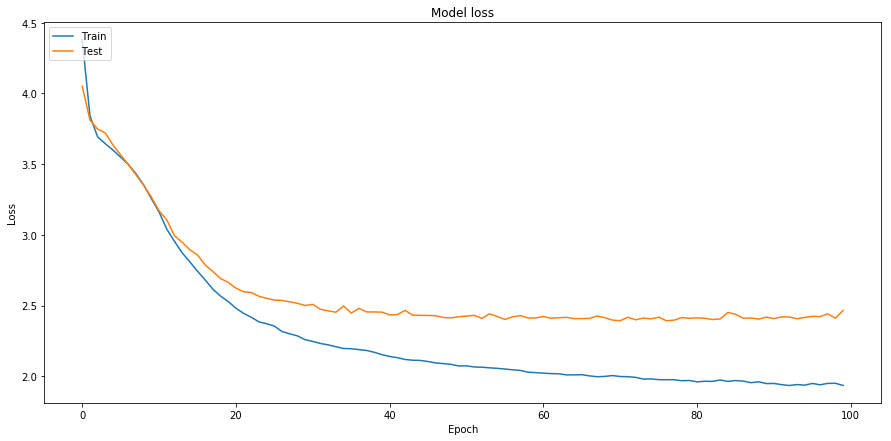

In [52]:
all_relevant_sequences = df_searches_per_country['city_integer_sequence'].values
all_relevant_sequences

max_seq_length = max([len(seq) for seq in all_relevant_sequences]) - 1
print('Maximum length of observed sequences : ' + str(max_seq_length))

# Save the time at which training starts so we can use it to create the paths in which we will store the model details.
training_start_time = np.datetime64('now')

# Create a path to store model details
path = 'models/per_country/{}'.format(str(training_start_time).replace(':', ''))

model, model_history, X_test, y_test = model_training_peipeline(all_relevant_sequences, max_seq_length, path)
plot_model_loss(model_history.history['loss'], model_history.history['val_loss'])

In [53]:
# Load our best ranking model to see how it performs on some random samples
path = 'models/per_country/{}'.format('2019-11-11T190152')
model_all_data = load_model(path)

print('------------------')
print('Cities most lilely to be searched next')
print('------------------')

# Set number of highest predictions given by the model to consider
number_of_most_relevant_predictions = 5

most_probable_cities = predict_most_likely_cities(model,input_city_names[0], 
                                                      number_of_most_relevant_predictions,
                                                      max_seq_length,
                                                      verbose=True)

print('Cities most lilely to be searched next: ' + str(most_probable_cities))

------------------
Cities most lilely to be searched next
------------------
Input city names: ['Vancouver BC', 'Victoria BC', 'Seattle WA', 'Portland OR', 'Stockton CA', 'Sacramento CA']
Input city tokens: [84, 85, 77, 63, 78, 67]
Padded  sequence: [[84 85 77 63 78 67  0  0  0  0]]
Prediction time:
1/1 [==============================] - 0s 263ms/step
Indexes of predictions with highest scores: [ 9 76 84 62 20]
Probability distributions: [0.06665718 0.08231593 0.5163572  0.11586331 0.09428702]
5 most probable cities: [85 63 21 77 10]
Decoded predictions: ['Victoria BC', 'Portland OR', 'Edmonton AB', 'Seattle WA', 'Calgary AB']
----
Cities most lilely to be searched next: ['Calgary AB', 'Edmonton AB']


In both cases the correct prediction was within the first five. For the first sample it is in the top one. The model seems to be 'working well'. Lets come up with a way to test our models that is more reliable.

<a id='cell_fourth_question'></a>
## Answer to fourth question

***Question: *** How did you measure the performance of the prediction algorithms from questions 2 and
3? What is your confidence that the measured score is accurate?

In order to be able to say how good a model is we need to come up with a fair way to score the predictions each model maked for us. We are going to predict the cities that are most likely to be searched next given a sequence and use those predictions to recommend new cities to be searched to a user, therefore our scoring approach must consider this.

### N-Ranking score


Let's define our own score. 

For a given model, one single observation and its corresponding label (ground truth) we can define a the N-Ranking score as 1 if the label value is in the set of N most likely cities to come next according to the model.

This score should capture the performance of our models sufficiently well since we will get to see hoe the N-Ranking score for each model changes in function of N. As N increases we expect to see the models having a bigger score since the chances of the labels showing up in the highest prediction increases. A model that scores 1 in more than 60% of the test samples in any N-Ranking score test with N < 5 will be considered remarcably good, since 60% of the times we would be presenting the user with a list of 5 city recommendations in which the city they are looking for is actually in.

When exploring a model performance it will be useful to run several model evaluations at the same time and have the results presented cleanly. This will be done below in a method named 'evaluate_all_models'.



## Evaluating the model formally

Let's create a method to calculate the N-Ranking score of a given model on a set of observed sequences and their corresponding labels.

In [54]:
def n_ranking_score(model, X_test, y_test, N, verbose=0):
    """
    Compute the n-ranking score for a given model on a set of observations with a set of corresponding labels and
    the number of predictions to consider
    
    :param model : Model to score.
    :param X_test: Set of observations for testing.
    :param y_test: Set of labels to verify the predictions with
    :param N     : number of highest ranking predictions to take for the score
    :return: Dictionary containing details of score.
    """
    X_predictions = model.predict(X_test,verbose=verbose)
    y_tokens = decode_vectors(y_test)
    
    score_counts = 0
    for idx, pred in enumerate(X_predictions):
        ordered_predictions = extract_most_relevant_predictions(pred, N)
        expected_y = y_tokens[idx]
        index_of_expected = np.where(ordered_predictions == expected_y)[0] 

        if index_of_expected.size > 0:
            score_counts += 1
        
    score_percentage = (score_counts*100)/len(X_test)
        
    return {'type':'Top {}'.format(N),
            'score_counts': score_counts,
            'score_pc':score_percentage,
            'samples': len(X_test)}

The following method will evaluate all the models in a given path, each model will be put through as many tests as first_n_ranks one for each n in [0, 1, ... , first_n_ranks-1]. All the results of the tests will be displayed together.

In [65]:
def evaluate_all_models(base_path, first_n_ranks, verbose=False):
    """
    Create the first 'first_n_ranks' n_rank reports of all the models saved in a given path.
    
    :param base_path : Path were models are saved.
    :param first_n_ranks: number of experiments to execute
    
    :return: Dataframe with scoring details of each model and each n-rank score.
    """
    dirlist = [ item for item in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, item))]
    if verbose:
        print('Found the following models: ' + str(dirlist))

    df_scores = pd.DataFrame(columns= ['Model', 'Type', 'Counts', 'Percentage', 'Samples'])
    model_paths = []
    model_types = []
    model_scores = []
    model_pctgs = []
    
    for mdir in dirlist:
        path = base_path + mdir
        model = load_model(path)
        model_loss = load_loss(path)
        
        if verbose:
            print('------------------')
            print('Model: ' + str(path))
            print(model.summary())
            
        plot_model_loss(model_loss['loss'], model_loss['val_loss'])
        
        for i in range(first_n_ranks):
            score = n_ranking_score(model, X_test, y_test, i+1, verbose=False)
            model_paths.append(path)
            model_scores.append(score['score_counts'])
            model_pctgs.append(score['score_pc'])
            model_types.append(score['type'])
        
    df_scores['Model'] = model_paths
    df_scores['Type'] = model_types
    df_scores['Counts'] = model_scores
    df_scores['Percentage'] = model_pctgs
    df_scores['Samples'] = [len(X_test)] * len(model_paths)

    return df_scores

Get the higest scoring models and print them so we can see them.

In [56]:
def highest_ranking_models(general_scores, highest_ranking_models):
    for i in range(number_of_most_relevant_predictions):
        experiment_type = 'Top ' + str(i+1)
        print('Best {} ranking models for experiment {}'.format(highest_ranking_models, experiment_type))
        top_scores = general_scores[general_scores['Type'] == experiment_type].sort_values(['Counts'], ascending=False)[:highest_ranking_models]
        print(top_scores.head())
        print('\n')
        

***Let's score all the models that where trained on all the data.***

To do so we'll make use of the evaluate_all_models() method. We'll pass a first_n_ranks of 5 to get the first five n-rank scores.


Found the following models: ['2019-11-11T191406', '2019-11-11T195345', '2019-11-11T190647']
------------------
Model: models/all_data/2019-11-11T191406
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 10, 100)           76000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 100)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_15 (Dense)             (None, 89)                8989      
Total params: 165,389
Trainable params: 165,389
Non-trainable params: 0
_________________________________________________________________
None


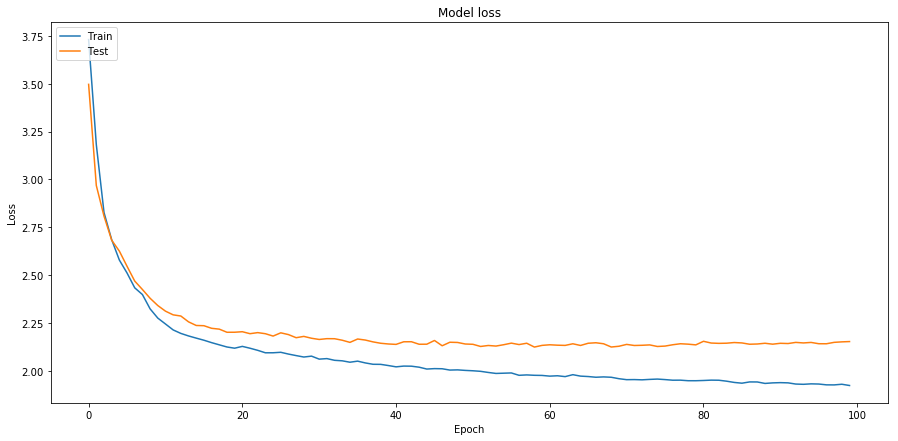

------------------
Model: models/all_data/2019-11-11T195345
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 10, 100)           76000     
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 100)           0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 10, 100)           80400     
_________________________________________________________________
dropout_20 (Dropout)         (None, 10, 100)           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_17 (Dense)             (None, 89)                8989      
Total params: 245,789
Trainable params: 245,789
Non-trainable params: 0
__________

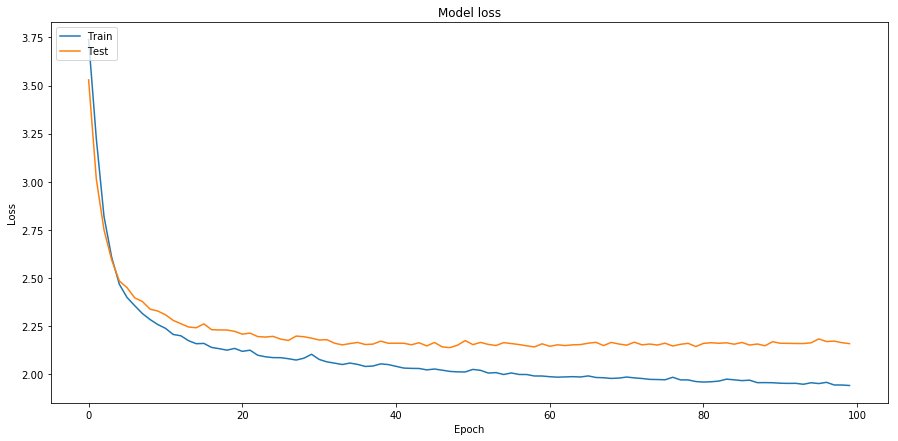

------------------
Model: models/all_data/2019-11-11T190647
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 10, 100)           76000     
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 100)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_14 (Dense)             (None, 89)                8989      
Total params: 165,389
Trainable params: 165,389
Non-trainable params: 0
_________________________________________________________________
None


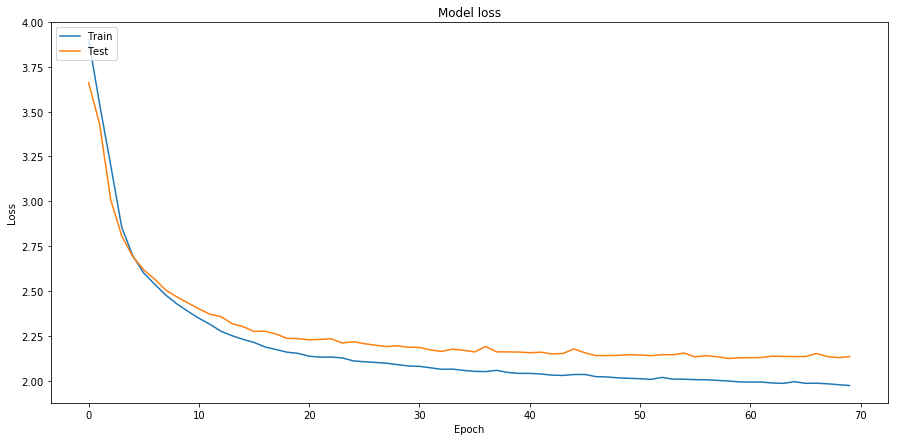

In [57]:
base_path = 'models/all_data/'
general_scores = evaluate_all_models(path=base_path, first_n_ranks = 5, verbose=True)

In [58]:
# general_scores.head()

In [59]:
print('------------ Model ranking ------------ \n')
highest_ranking_models(general_scores, highest_ranking_models = 3)

------------ Model ranking ------------ 

Best 3 ranking models for experiment Top 1
                                Model   Type  Counts  Percentage  Samples
0   models/all_data/2019-11-11T191406  Top 1     139   27.689243      502
5   models/all_data/2019-11-11T195345  Top 1     131   26.095618      502
10  models/all_data/2019-11-11T190647  Top 1     130   25.896414      502


Best 3 ranking models for experiment Top 2
                                Model   Type  Counts  Percentage  Samples
6   models/all_data/2019-11-11T195345  Top 2     227   45.219124      502
1   models/all_data/2019-11-11T191406  Top 2     221   44.023904      502
11  models/all_data/2019-11-11T190647  Top 2     218   43.426295      502


Best 3 ranking models for experiment Top 3
                                Model   Type  Counts  Percentage  Samples
12  models/all_data/2019-11-11T190647  Top 3     299   59.561753      502
7   models/all_data/2019-11-11T195345  Top 3     298   59.362550      502
2   models/

### Model results on all data

First of all, let's remember that when Google proposes search options to us it usually shows us between 7 and 10 options and usually if we see the search string that we were struggling to type in the proposed list we have a very good experience.

Having this in mind we will consider a model that correctly predicts the city the user was going to type within a list of 5 predictions more than 70% of the times a very good model.

We have computed the first 5 n-rank score for all the models we trained and displayed them above. We can see that our LSTMs perform differently for different values of N.

A very good candidate to be tested in a production environment would be the model at path 'models/all_data/2019-11-11T190647' the highest ranking model in the top 3 and 5 categories. This model will predict the correct city among a list of 5 others 75.9% of the time. This is an amazing performance for a model that only learned from a bit over 9000 data points.



***Let's score all the models that where trained data for the US.***



Found the following models: ['2019-11-12T223642', '2019-11-11T190647', '2019-11-11T190152']
------------------
Model: models/per_country/2019-11-12T223642
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 100)           76000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 89)                8989      
Total params: 165,389
Trainable params: 165,389
Non-trainable params: 0
_________________________________________________________________
None


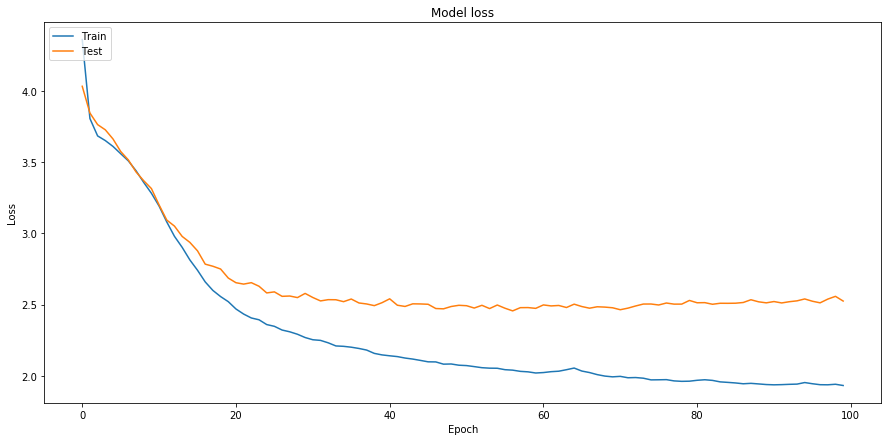

------------------
Model: models/per_country/2019-11-11T190647
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 160)               160000    
_________________________________________________________________
dense_13 (Dense)             (None, 89)                14329     
Total params: 174,329
Trainable params: 174,329
Non-trainable params: 0
_________________________________________________________________
None


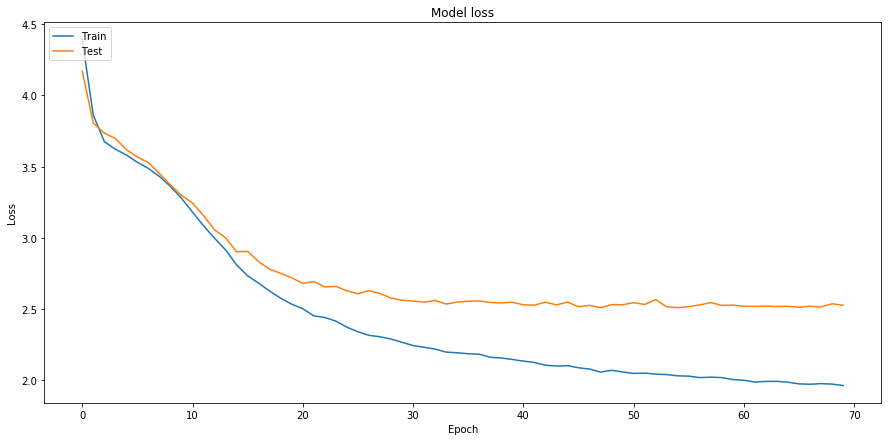

------------------
Model: models/per_country/2019-11-11T190152
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 10, 100)           76000     
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 100)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 89)                8989      
Total params: 165,389
Trainable params: 165,389
Non-trainable params: 0
_________________________________________________________________
None


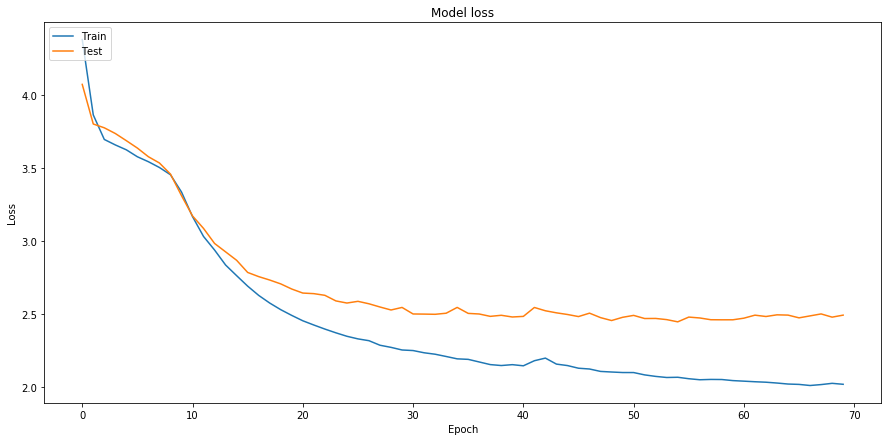

In [68]:
base_path = 'models/per_country/'
general_scores = evaluate_all_models(base_path, first_n_ranks=5, verbose=True)

In [69]:
print('------------ Model ranking ------------ \n')
highest_ranking_models(general_scores, 3)

------------ Model ranking ------------ 

Best 3 ranking models for experiment Top 1
                                   Model   Type  Counts  Percentage  Samples
10  models/per_country/2019-11-11T190152  Top 1     123   24.501992      502
0   models/per_country/2019-11-12T223642  Top 1     121   24.103586      502
5   models/per_country/2019-11-11T190647  Top 1     116   23.107570      502


Best 3 ranking models for experiment Top 2
                                   Model   Type  Counts  Percentage  Samples
1   models/per_country/2019-11-12T223642  Top 2     202   40.239044      502
11  models/per_country/2019-11-11T190152  Top 2     195   38.844622      502
6   models/per_country/2019-11-11T190647  Top 2     193   38.446215      502


Best 3 ranking models for experiment Top 3
                                   Model   Type  Counts  Percentage  Samples
7   models/per_country/2019-11-11T190647  Top 3     260   51.792829      502
12  models/per_country/2019-11-11T190152  Top 3     259

The models trained on only data for the US did not perform better than the models trained over all the data. This is specific to the type of model that we used since for DNNs usually the more meaningful data the better.

Also considering the fact that we had around 4/5 less data when training for only one country the models still performed decently well on the tests. It would be interesting to retrain very similar models with more data for the same country and see if the performance gets better.

For this project I used LSTM based models since they are great for learning from sequences and they are among the most powerful RNNs. Other approaches could also be considered such as HMMs or Compact Prediction Trees
